A binary classification model was developed to classify SMS messages as spam or ham, utilizing deep learning techniques like an embedding layer, Bidirectional LSTM, and dense layers.

**Dataset:** SMS Spam Collection (FreeCodeCamp)

**Performance:** 99.7% training accuracy, 98.9% validation accuracy

**Text Preprocessing:** Lowercasing, punctuation removal, lemmatization, and stopword filtering

The model performed well, providing valuable hands-on experience in applying deep learning to practical text classification tasks.

In [48]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

print(tf.__version__)

2.20.0-dev20250403


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"



--2025-04-04 14:02:31--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.6’

train-data.tsv.6    100%[===================>] 349.84K  --.-KB/s    in 0.06s   

2025-04-04 14:02:31 (5.53 MB/s) - ‘train-data.tsv.6’ saved [358233/358233]

--2025-04-04 14:02:31--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.6’

valid-data.tsv.6    100%[========

In [50]:
# Load datasets and add labels
train_df = pd.read_csv("train-data.tsv", sep='\t', header=None, names=["label", "message"])
test_df = pd.read_csv("valid-data.tsv", sep='\t', header=None, names=["label", "message"])

# Map labels: ham = 0, spam = 1
train_df['label'] = train_df['label'].map({'ham': 0, 'spam': 1})
test_df['label'] = test_df['label'].map({'ham': 0, 'spam': 1})


In [51]:
stopwords_eng = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess the text: lowercase, remove symbols and stopwords
def clean_txt(txt):
    txt = txt.lower()
    txt = re.sub(r'[^\w\s£$]', '', txt)
    txt = re.sub(r'\s+', ' ', txt)
    return " ".join([
        lemmatizer.lemmatize(word)
        for word in txt.split()
        if word not in stopwords_eng
    ])


X_train = train_df['message'].apply(clean_txt)
X_test = test_df['message'].apply(clean_txt)
y_train = train_df['label']
y_test = test_df['label']


In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_words = 5000
max_len = 100

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)


In [53]:
from tensorflow.keras import regularizers

# Build the model: Embedding + BiLSTM + Dense
input_ = tf.keras.layers.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(max_words, 64)(input_)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=input_, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,369 (1.50 MB)

 Trainable params: 394,369 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the model with early stopping
model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])



Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 332ms/step - accuracy: 0.8673 - loss: 0.5179 - val_accuracy: 0.8612 - val_loss: 0.3854
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.8625 - loss: 0.3678 - val_accuracy: 0.9270 - val_loss: 0.2339
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.9438 - loss: 0.1902 - val_accuracy: 0.9844 - val_loss: 0.0673
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.9901 - loss: 0.0458 - val_accuracy: 0.9904 - val_loss: 0.0513
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.9929 - loss: 0.0261 - val_accuracy: 0.9892 - val_loss: 0.0503
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.9959 - loss: 0.0184 - val_accuracy: 0.9892 - val_loss: 0.0509
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.9979 - loss: 0.0137 - val_accuracy: 0.9868 - val_loss: 0.0630


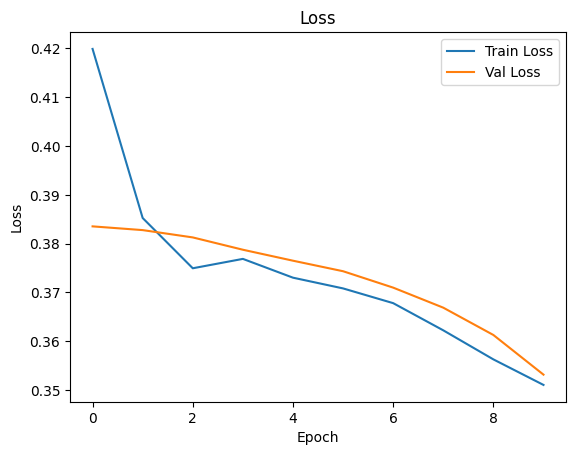

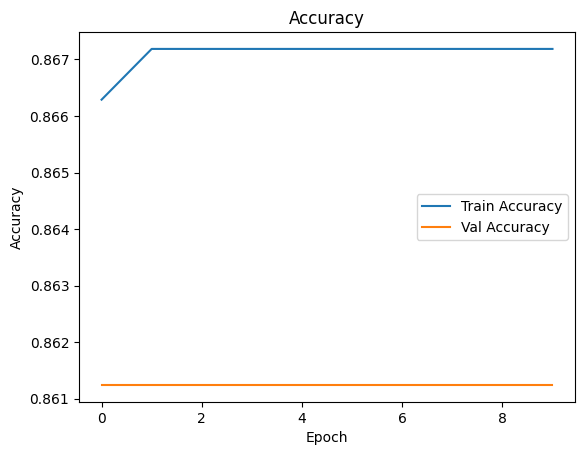

In [55]:
# Plot training history
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def preprocessing(X):
    x = X.apply(clean_txt)
    x = tokenizer.texts_to_sequences(x)
    return sequence.pad_sequences(x, maxlen=max_len)

def predict_message(msg):
    x = preprocessing(pd.Series([msg]))
    p = model.predict(x)[0][0]
    return [float(p), "ham" if p < 0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
[0.002538697561249137, 'ham']


In [57]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
You passed the challenge. Great job!


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


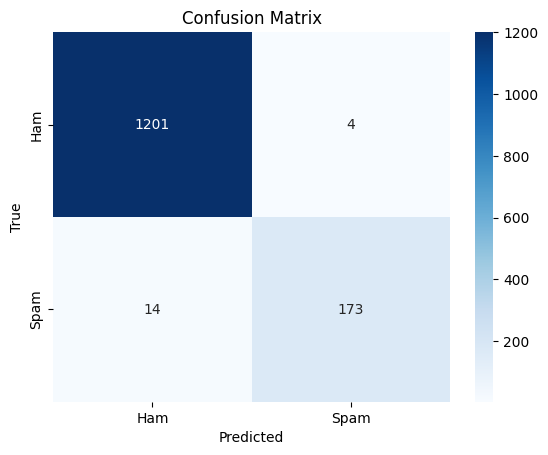

              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      1205
        Spam       0.98      0.93      0.95       187

    accuracy                           0.99      1392
   macro avg       0.98      0.96      0.97      1392
weighted avg       0.99      0.99      0.99      1392



In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=['Ham', 'Spam']))


### Evaluation

After training and evaluating my spam classifier model, I analyzed the predictions using a confusion matrix and classification report. Here's a summary of the model's final performance:

- **Accuracy:** 99%
- **Precision (spam):** 98%
- **Recall (spam):** 93%
- **F1-Score (spam):** 0.95  
- **Confusion Matrix:**
  - 1201 ham messages correctly classified
  - 173 spam messages correctly classified
  - Only 18 misclassifications (4 false positives, 14 false negatives)

These results indicate that the model generalizes very well, with minimal overfitting. The recall value for spam is slightly lower than for hams.

Overall, I'm very satisfied with the model's performance. It successfully passed the challenge test and showed strong results in precision, recall, and general accuracy. This project helped me understand how to preprocess text data, build a neural network with LSTM layers, and evaluate a classification model using real metrics.
